In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
sns.set_style('white')

import datetime as dt

In [2]:
hdb_2000_2012 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
hdb_2012_2014 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
hdb_2015_2016 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2015-to-dec-2016.csv')
hdb_2017_2020 = pd.read_csv('./dataset/resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [3]:
print(hdb_2000_2012.shape)
print(hdb_2012_2014.shape)
print(hdb_2015_2016.shape)
print(hdb_2017_2020.shape)

(369651, 10)
(52203, 10)
(37153, 11)
(66497, 11)


In [4]:
hdb = pd.concat([hdb_2000_2012, hdb_2012_2014, hdb_2015_2016, hdb_2017_2020], axis=0, join='outer', sort=False)

# transform date columns
hdb['month'] = pd.to_datetime(hdb['month'])
hdb['lease_commence_date'] = pd.to_datetime(hdb['lease_commence_date'], format='%Y')

# creating more date columns
hdb['year_sold'] = hdb['month'].dt.year

# impute remaining lease
hdb['remaining_lease_in_years'] = 99 - (hdb['month'].dt.year - hdb['lease_commence_date'].dt.year)

# get remaining lease buckets
hdb['remaining_lease_in_5Y_buckets'] = hdb['remaining_lease_in_years'].apply(lambda x: x//5*5)

# lease commence year
hdb['lease_commence_year'] = hdb['lease_commence_date'].dt.year

# square feet
hdb['floor_area_sqft'] = hdb['floor_area_sqm'] * 10.7639

# price per square feet
hdb['price_per_sqft'] = hdb['resale_price'] / hdb['floor_area_sqft']

hdb = hdb[['month', 'year_sold', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 
           'floor_area_sqft', 'price_per_sqft', 'flat_model', 'lease_commence_date', 'lease_commence_year', 
           'remaining_lease_in_years', 'remaining_lease_in_5Y_buckets', 'resale_price']]

# export dataset
hdb.to_csv('./dataset/hdb_2000_2020.csv')

In [5]:
hdb.head(2)

month  year_sold        town flat_type block       street_name  \
0 2000-01-01       2000  ANG MO KIO    3 ROOM   170  ANG MO KIO AVE 4   
1 2000-01-01       2000  ANG MO KIO    3 ROOM   174  ANG MO KIO AVE 4   

  storey_range  floor_area_sqm  floor_area_sqft  price_per_sqft flat_model  \
0     07 TO 09            69.0         742.7091      197.924059   Improved   
1     04 TO 06            61.0         656.5979      219.312307   Improved   

  lease_commence_date  lease_commence_year  remaining_lease_in_years  \
0          1986-01-01                 1986                        85   
1          1986-01-01                 1986                        85   

   remaining_lease_in_5Y_buckets  resale_price  
0                             85      147000.0  
1                             85      144000.0

In [6]:
flats_sold_per_town = hdb['town'].value_counts().reset_index().rename(columns={'index': 'town', 
                                                                               'town': 'num_flats'})

fig = px.bar(flats_sold_per_town, x='town', y='num_flats', width=1000, height=450)

In [7]:
TOWN_TIER_1_PRX = ['Ang Mo Kio', 'Bishan', 'Geylang', 'Kallang/Whampoa', 'Serangoon', 'Toa Payoh']
TOWN_TIER_1_NOPRX = ['Bukit Merah', 'Queenstown', 'Central Area']

TOWN_TIER_2 = ['Bedok', 'Clementi', 'Hougang', 'Punggol', 'Sengkang']

TOWN_TIER_3 = ['Bukit Panjang', 'Bukit Batok', 'Bukit Timah', 'Choa Chu Kang', 'Jurong East', 'Jurong West', 
               'Marine Parade', 'Pasir Ris', 'Sembawang', 'Tampines', 'Woodlands', 'Yishun']

# changing all to upper case
TOWN_TIER_1_PRX = [town.upper() for town in TOWN_TIER_1_PRX]
TOWN_TIER_1_NOPRX = [town.upper() for town in TOWN_TIER_1_NOPRX]
TOWN_TIER_2 = [town.upper() for town in TOWN_TIER_2]
TOWN_TIER_3 = [town.upper() for town in TOWN_TIER_3]

In [8]:
flats_sold_per_flat_type = hdb['flat_type'].value_counts().reset_index().rename(columns={'index': 'flat_type', 
                                                                                         'flat_type': 'num_flats'})

px.bar(flats_sold_per_flat_type, x='flat_type', y='num_flats', width=600, height=400)

In [9]:
# instantiating masks

four_room_and_above = hdb['flat_type'].isin(['4 ROOM', '5 ROOM', 'EXECUTIVE'])
years_2010_2019 = (hdb['year_sold']>=2010) & (hdb['year_sold']<=2019)
years_2000_2019 = (hdb['year_sold']>=2000) & (hdb['year_sold']<=2019)
loc_tier1 = hdb['town'].isin(TOWN_TIER_1_PRX + TOWN_TIER_1_NOPRX)

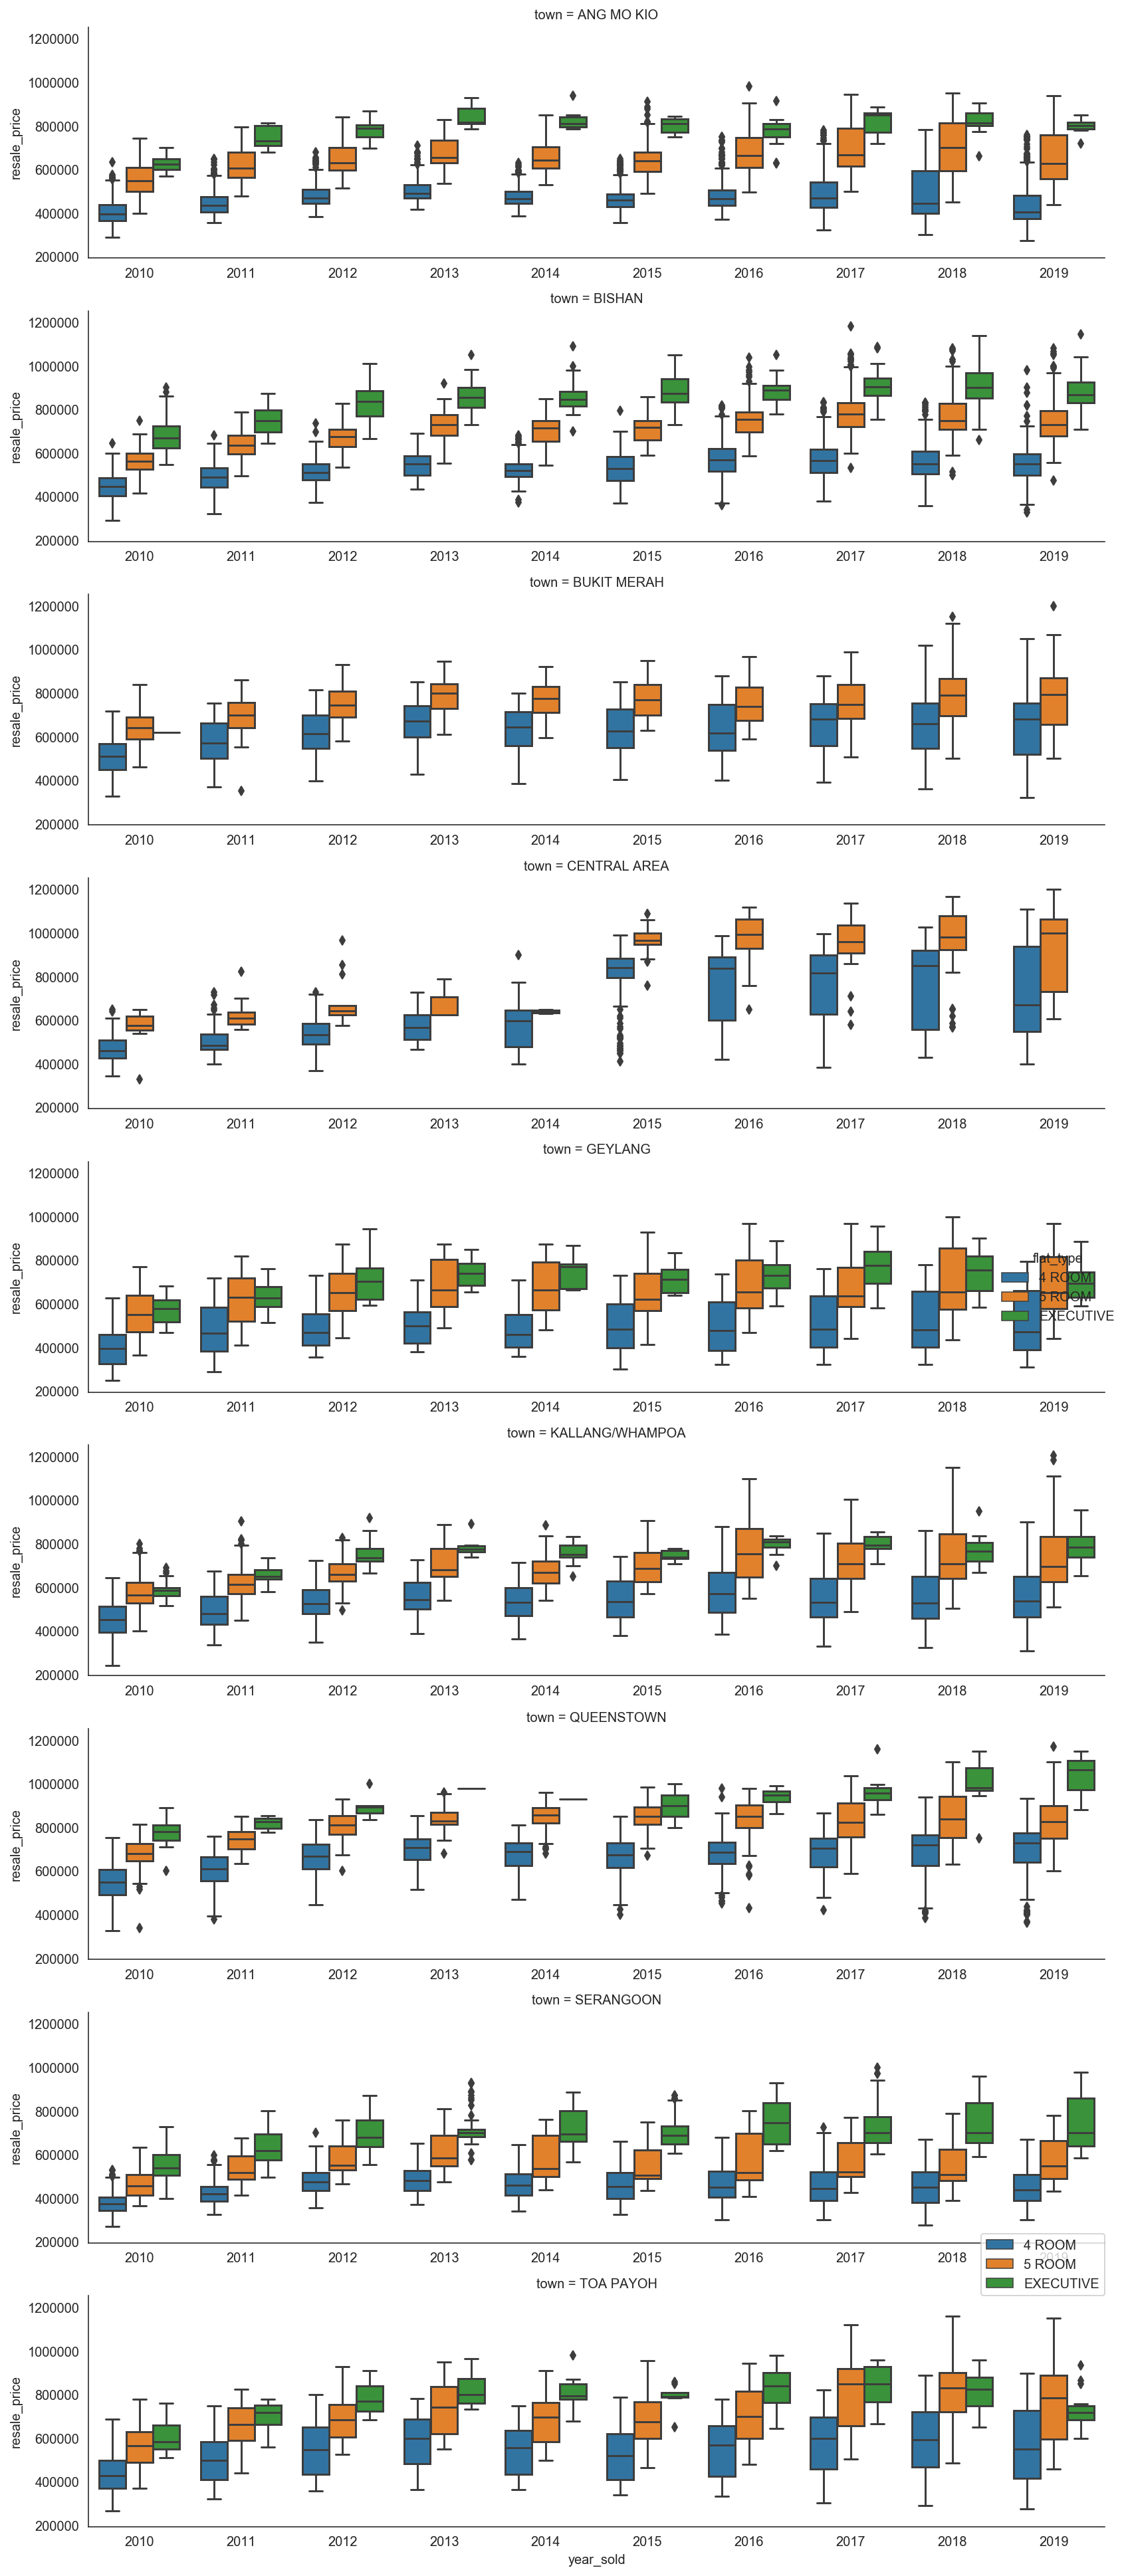

In [10]:
g = sns.catplot(x='year_sold', y='resale_price', kind='box', hue='flat_type', col='town', col_wrap=1, 
            data=hdb[four_room_and_above & years_2010_2019 & loc_tier1], 
            aspect=3.5, height=3, legend_out=True);

for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)

g.fig.tight_layout()
plt.legend(bbox_to_anchor=(1, 1), loc=4, borderaxespad=0.);

In [11]:
hdb_4room_plus = hdb[four_room_and_above].sort_values(by='resale_price', ascending=False)
hdb_4room_plus.shape

(363301, 16)

In [12]:
yearly_resale_prices_4roomsplus = (hdb_4room_plus
                                   .groupby('year_sold')
                                   .agg({'resale_price': [np.mean, np.median],
                                        'price_per_sqft': [np.mean, np.median]
                                        }
                                       )
                                  )

# tidy format for plotting in plotly
yearly_resale_prices_4roomsplus_tidy = (yearly_resale_prices_4roomsplus
                                        .stack()
                                        .reset_index()
                                        .rename(columns={'level_1':'central_tendency'})
                                       )

In [13]:
px.line(yearly_resale_prices_4roomsplus_tidy, 
        x='year_sold', y='resale_price', color='central_tendency', 
        width=800, height=400)

In [14]:
hdb_4room_plus_tier_1 = hdb[four_room_and_above & loc_tier1]
hdb_4room_plus_tier_1.shape

(65085, 16)

In [15]:
yearly_resale_prices_4roomsplus_tier1 = (hdb_4room_plus_tier_1
                                         .groupby('year_sold')
                                         .agg({'resale_price': [np.mean, np.median],
                                               'price_per_sqft': [np.mean, np.median]
                                              }
                                             )
                                        )

# tidy format for plotting in plotly
yearly_resale_prices_4roomsplus_tier1_tidy = (yearly_resale_prices_4roomsplus_tier1
                                              .stack()
                                              .reset_index()
                                              .rename(columns={'level_1':'central_tendency'})
                                             )

In [16]:
px.line(yearly_resale_prices_4roomsplus_tier1_tidy, 
        x='year_sold', y='resale_price', color='central_tendency', 
        width=800, height=400)

In [17]:
px.line(yearly_resale_prices_4roomsplus_tier1_tidy, 
        x='year_sold', y='price_per_sqft', color='central_tendency', 
        width=800, height=400)

In [18]:
resale_prices_4roomsplus_tier1_by_year_built = (hdb_4room_plus_tier_1
                                                .groupby('lease_commence_year')
                                                .agg({'resale_price': [np.mean, np.median],
                                                      'price_per_sqft': [np.mean, np.median]
                                                     }
                                                    )
                                               )

# tidy format for plotting in plotly
resale_prices_4roomsplus_tier1_by_year_built_tidy = (resale_prices_4roomsplus_tier1_by_year_built
                                                     .stack()
                                                     .reset_index()
                                                     .rename(columns={'level_1':'central_tendency'})
                                                    )

px.line(resale_prices_4roomsplus_tier1_by_year_built_tidy, 
        x='lease_commence_year', y='resale_price', color='central_tendency',
        width=800, height=400)

In [19]:
px.line(resale_prices_4roomsplus_tier1_by_year_built_tidy, 
        x='lease_commence_year', y='price_per_sqft', color='central_tendency',
        width=800, height=400)

In [20]:
resale_price_by_year_sold_remaining_lease = (hdb_4room_plus_tier_1
                                             .groupby(['year_sold', 'remaining_lease_in_5Y_buckets'])
                                             .agg({'resale_price': [np.mean, np.median, 'count'],
                                                   'price_per_sqft': [np.mean, np.median, 'count']
                                                  }
                                                 )
                                            )

# mean
mean_columns = resale_price_by_year_sold_remaining_lease.columns.get_level_values(1)=='mean'
mean_resale_price_tidy = resale_price_by_year_sold_remaining_lease.iloc[:, mean_columns]
mean_resale_price_tidy.columns = mean_resale_price_tidy.columns.droplevel(1)
mean_resale_price_tidy = mean_resale_price_tidy.reset_index().sort_values(by=['year_sold', 
                                                                              'remaining_lease_in_5Y_buckets'])

# median
median_columns = resale_price_by_year_sold_remaining_lease.columns.get_level_values(1)=='median'
median_resale_price_tidy = resale_price_by_year_sold_remaining_lease.iloc[:, median_columns]
median_resale_price_tidy.columns = median_resale_price_tidy.columns.droplevel(1)
median_resale_price_tidy = median_resale_price_tidy.reset_index().sort_values(by=['year_sold', 
                                                                              'remaining_lease_in_5Y_buckets'])

# volume
volume_columns = resale_price_by_year_sold_remaining_lease.columns.get_level_values(1)=='count'
volume_resale_price_tidy = resale_price_by_year_sold_remaining_lease.iloc[:, volume_columns]
volume_resale_price_tidy.columns = volume_resale_price_tidy.columns.droplevel(1)
volume_resale_price_tidy = volume_resale_price_tidy.reset_index().rename(columns={'resale_price': 'volume_sold'})

# changing remaining lease and year sold to str so that plotly treats it as a categorical variable
mean_resale_price_tidy['year_sold'] = mean_resale_price_tidy['year_sold'].apply(str)
median_resale_price_tidy['year_sold'] = median_resale_price_tidy['year_sold'].apply(str)
volume_resale_price_tidy['year_sold'] = volume_resale_price_tidy['year_sold'].apply(str)

mean_resale_price_tidy['remaining_lease_in_5Y_buckets'] = mean_resale_price_tidy['remaining_lease_in_5Y_buckets'].apply(str)
median_resale_price_tidy['remaining_lease_in_5Y_buckets'] = median_resale_price_tidy['remaining_lease_in_5Y_buckets'].apply(str)
volume_resale_price_tidy['remaining_lease_in_5Y_buckets'] = volume_resale_price_tidy['remaining_lease_in_5Y_buckets'].apply(str)

In [21]:
px.line(median_resale_price_tidy,
        x='year_sold', y='resale_price', color='remaining_lease_in_5Y_buckets',
        width=900, height=400,
        category_orders={'remaining_lease_in_5Y_buckets':['45', '50', '55', '60', '65', 
                                                         '70', '75', '80', '85', '90', '95', '100']})

In [22]:
fig = px.line(median_resale_price_tidy,
              x='remaining_lease_in_5Y_buckets', y='resale_price', color='year_sold',
              width=900, height=600, 
              category_orders={'year_sold':[str(yr) for yr in range(2000, 2021)]})

fig['layout']['xaxis']['autorange']= 'reversed'
fig.show()

In [42]:
resale_price_depreciation_by_remaining_lease = (
    resale_price_by_year_sold_remaining_lease
    .loc[2010:2020]
    .sort_values(by=['year_sold','remaining_lease_in_5Y_buckets'],
                 ascending=[True, False])
    ['resale_price'][['mean']]
)

In [43]:
# transform reference: https://pbpython.com/pandas_transform.html

#cumulative
resale_price_depreciation_by_remaining_lease['cumulative_pct_change'] = (
    resale_price_depreciation_by_remaining_lease['mean'] / 
    resale_price_depreciation_by_remaining_lease.groupby(level=['year_sold']).transform('first')['mean'] -1
)

resale_price_depreciation_by_remaining_lease['cumulative_pct_change'] = (
    resale_price_depreciation_by_remaining_lease['cumulative_pct_change'].apply(lambda x: round(x*100, 2))
)

# not cumulative
resale_price_depreciation_by_remaining_lease['pct_change'] = (
    resale_price_depreciation_by_remaining_lease
    .groupby(level='year_sold')['mean']
    .pct_change()
)
resale_price_depreciation_by_remaining_lease['pct_change'] = (
    resale_price_depreciation_by_remaining_lease['pct_change'].apply(lambda x: round(x*100, 2))
)

resale_price_depreciation_by_remaining_lease_tidy = resale_price_depreciation_by_remaining_lease.reset_index()

In [44]:
fig = px.line(resale_price_depreciation_by_remaining_lease_tidy, 
        x='remaining_lease_in_5Y_buckets', y='cumulative_pct_change', color='year_sold')
fig['layout']['xaxis']['autorange']= 'reversed'
fig.show()

In [77]:
resale_price_depreciation_by_remaining_lease

mean  cumulative_pct_change  \
year_sold remaining_lease_in_5Y_buckets                                         
2010      95                             617885.428018                   0.00   
          90                             590345.047359                  -4.46   
          85                             547577.429530                 -11.38   
          80                             522336.681716                 -15.46   
          75                             474942.962804                 -23.13   
          70                             444340.991094                 -28.09   
          65                             461676.806029                 -25.28   
          60                             450885.850622                 -27.03   
          55                             461347.368421                 -25.33   
2011      100                            616000.000000                   0.00   
          95                             679367.909091                  10.29   
          90                             655721.750000                   6.45   
          85                             597235.002865                  -3.05   
          80                             579308.981622                  -5.96   
          75                             540214.757042                 -12.30   
          70                             493005.106719                 -19.97   
          65                             498853.477573                 -19.02   
          60                             495940.935484                 -19.49   
          55                             500157.894737                 -18.81   
2012      95                             746441.500000                   0.00   
          90                             696955.427397                  -6.63   
          85                             665362.192090                 -10.86   
          80                             656180.271786                 -12.09   
          75                             584704.403458                 -21.67   
          70                             556774.931987                 -25.41   
          65                             533805.596244                 -28.49   
          60                             523335.819936                 -29.89   
          55                             542259.960000                 -27.35   
          50                             590000.000000                 -20.96   
2013      95                             721456.035714                   0.00   
...                                                ...                    ...   
2018      85                             722348.653992                 -20.47   
          80                             698112.267717                 -23.14   
          75                             684799.016181                 -24.60   
          70                             614104.610932                 -32.39   
          65                             574921.350734                 -36.70   
          60                             534302.164384                 -41.17   
          55                             499171.581121                 -45.04   
          50                             465575.866667                 -48.74   
          45                             858000.000000                  -5.53   
2019      95                             885799.571429                   0.00   
          90                             837488.584906                  -5.45   
          85                             752121.247458                 -15.09   
          80                             691774.852761                 -21.90   
          75                             679082.761566                 -23.34   
          70                             599264.970711                 -32.35   
          65                             574969.303777                 -35.09   
          60                             533982.638522                 -39.72   


In [63]:
resale_price_depreciation_by_remaining_lease['sell_in_5Y'] = (
    resale_price_depreciation_by_remaining_lease.groupby(level='year_sold')['mean'].pct_change(periods=1).shift(-1)
)
resale_price_depreciation_by_remaining_lease['sell_in_10Y'] = (
    resale_price_depreciation_by_remaining_lease.groupby(level='year_sold')['mean'].pct_change(periods=2).shift(-2)
)

resale_price_depreciation_by_remaining_lease['sell_in_15Y'] = (
    resale_price_depreciation_by_remaining_lease.groupby(level='year_sold')['mean'].pct_change(periods=3).shift(-3)
)

resale_price_depreciation_by_remaining_lease['sell_in_20Y'] = (
    resale_price_depreciation_by_remaining_lease.groupby(level='year_sold')['mean'].pct_change(periods=4).shift(-4)
)

resale_price_depreciation_by_remaining_lease

mean  cumulative_pct_change  \
year_sold remaining_lease_in_5Y_buckets                                         
2010      95                             617885.428018                   0.00   
          90                             590345.047359                  -4.46   
          85                             547577.429530                 -11.38   
          80                             522336.681716                 -15.46   
          75                             474942.962804                 -23.13   
          70                             444340.991094                 -28.09   
          65                             461676.806029                 -25.28   
          60                             450885.850622                 -27.03   
          55                             461347.368421                 -25.33   
2011      100                            616000.000000                   0.00   
          95                             679367.909091                  10.29   
          90                             655721.750000                   6.45   
          85                             597235.002865                  -3.05   
          80                             579308.981622                  -5.96   
          75                             540214.757042                 -12.30   
          70                             493005.106719                 -19.97   
          65                             498853.477573                 -19.02   
          60                             495940.935484                 -19.49   
          55                             500157.894737                 -18.81   
2012      95                             746441.500000                   0.00   
          90                             696955.427397                  -6.63   
          85                             665362.192090                 -10.86   
          80                             656180.271786                 -12.09   
          75                             584704.403458                 -21.67   
          70                             556774.931987                 -25.41   
          65                             533805.596244                 -28.49   
          60                             523335.819936                 -29.89   
          55                             542259.960000                 -27.35   
          50                             590000.000000                 -20.96   
2013      95                             721456.035714                   0.00   
...                                                ...                    ...   
2018      85                             722348.653992                 -20.47   
          80                             698112.267717                 -23.14   
          75                             684799.016181                 -24.60   
          70                             614104.610932                 -32.39   
          65                             574921.350734                 -36.70   
          60                             534302.164384                 -41.17   
          55                             499171.581121                 -45.04   
          50                             465575.866667                 -48.74   
          45                             858000.000000                  -5.53   
2019      95                             885799.571429                   0.00   
          90                             837488.584906                  -5.45   
          85                             752121.247458                 -15.09   
          80                             691774.852761                 -21.90   
          75                             679082.761566                 -23.34   
          70                             599264.970711                 -32.35   
          65                             574969.303777                 -35.09   
          60                             533982.638522                 -39.72   


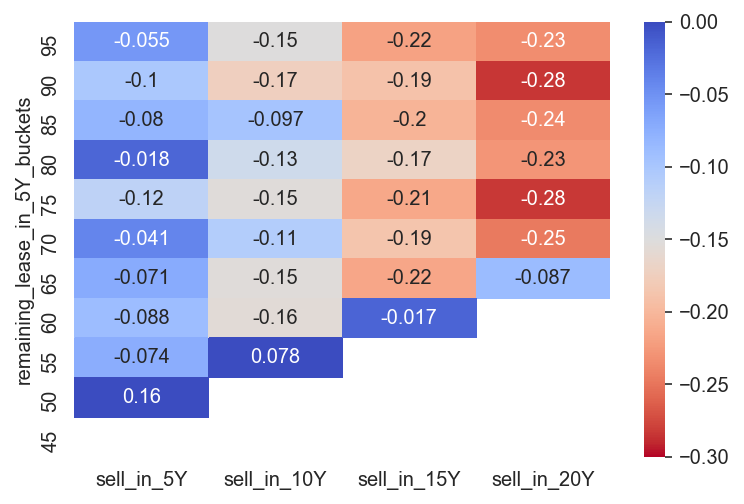

In [76]:
sns.heatmap(resale_price_depreciation_by_remaining_lease.loc[2019]
            [['sell_in_5Y', 'sell_in_10Y', 'sell_in_15Y', 'sell_in_20Y']], annot=True, vmin=-0.3, vmax=0, 
            cmap='coolwarm_r')

Based on trends in 2018 and 2019:
- If the intention is to sell it after 10 years, then buying a younger house (higher remaining lease) doesn't look to be always better, because the flat is more expensive when you buy it, and it sees a steeper drop
    - E.g. If you buy a house with 95 years left in 2018 and sold it when it had 85 years left, the value drops by 20%. but if you bought it for cheaper at 85Y, and sold it at 75Y, you make less of a loss!

In [26]:
# Does rate of depreciation differ between resale price ranges / town / sqft?
# e.g. the more expensive the house, the higher the depreciation. or certain towns have higher depreciation?

In [27]:
# not so relevant
fig = px.line(resale_price_depreciation_by_remaining_lease_tidy, 
        x='remaining_lease_in_5Y_buckets', y='pct_change', color='year_sold')
fig['layout']['xaxis']['autorange']= 'reversed'
fig.show()

In [28]:
# who are the houses that are sold 45 years lease remaining in 2018 and 2019??
hdb_4room_plus_tier_1[hdb_4room_plus_tier_1['remaining_lease_in_years']<50][['year_sold', 'town', 'flat_type', 
                                                                         'floor_area_sqft', 'flat_model', 
                                                                         'lease_commence_date', 'resale_price']]

year_sold        town flat_type  floor_area_sqft     flat_model  \
37866       2018  QUEENSTOWN    4 ROOM        1076.3900        Terrace   
44774       2019  QUEENSTOWN    4 ROOM        1367.0153  Adjoined flat   
61901       2019  QUEENSTOWN    4 ROOM         990.2788  Adjoined flat   

      lease_commence_date  resale_price  
37866          1968-01-01      858000.0  
44774          1967-01-01      650000.0  
61901          1967-01-01      400000.0

In [29]:
# is it possible to sell a 50 year old flat? how easy is it to sell a 50 year old flat
flats_sold_counts = (
    hdb_4room_plus_tier_1[['year_sold', 'remaining_lease_in_years', 'resale_price']]
    .groupby(['year_sold', 'remaining_lease_in_years'])
    .size()
    .reset_index()
)

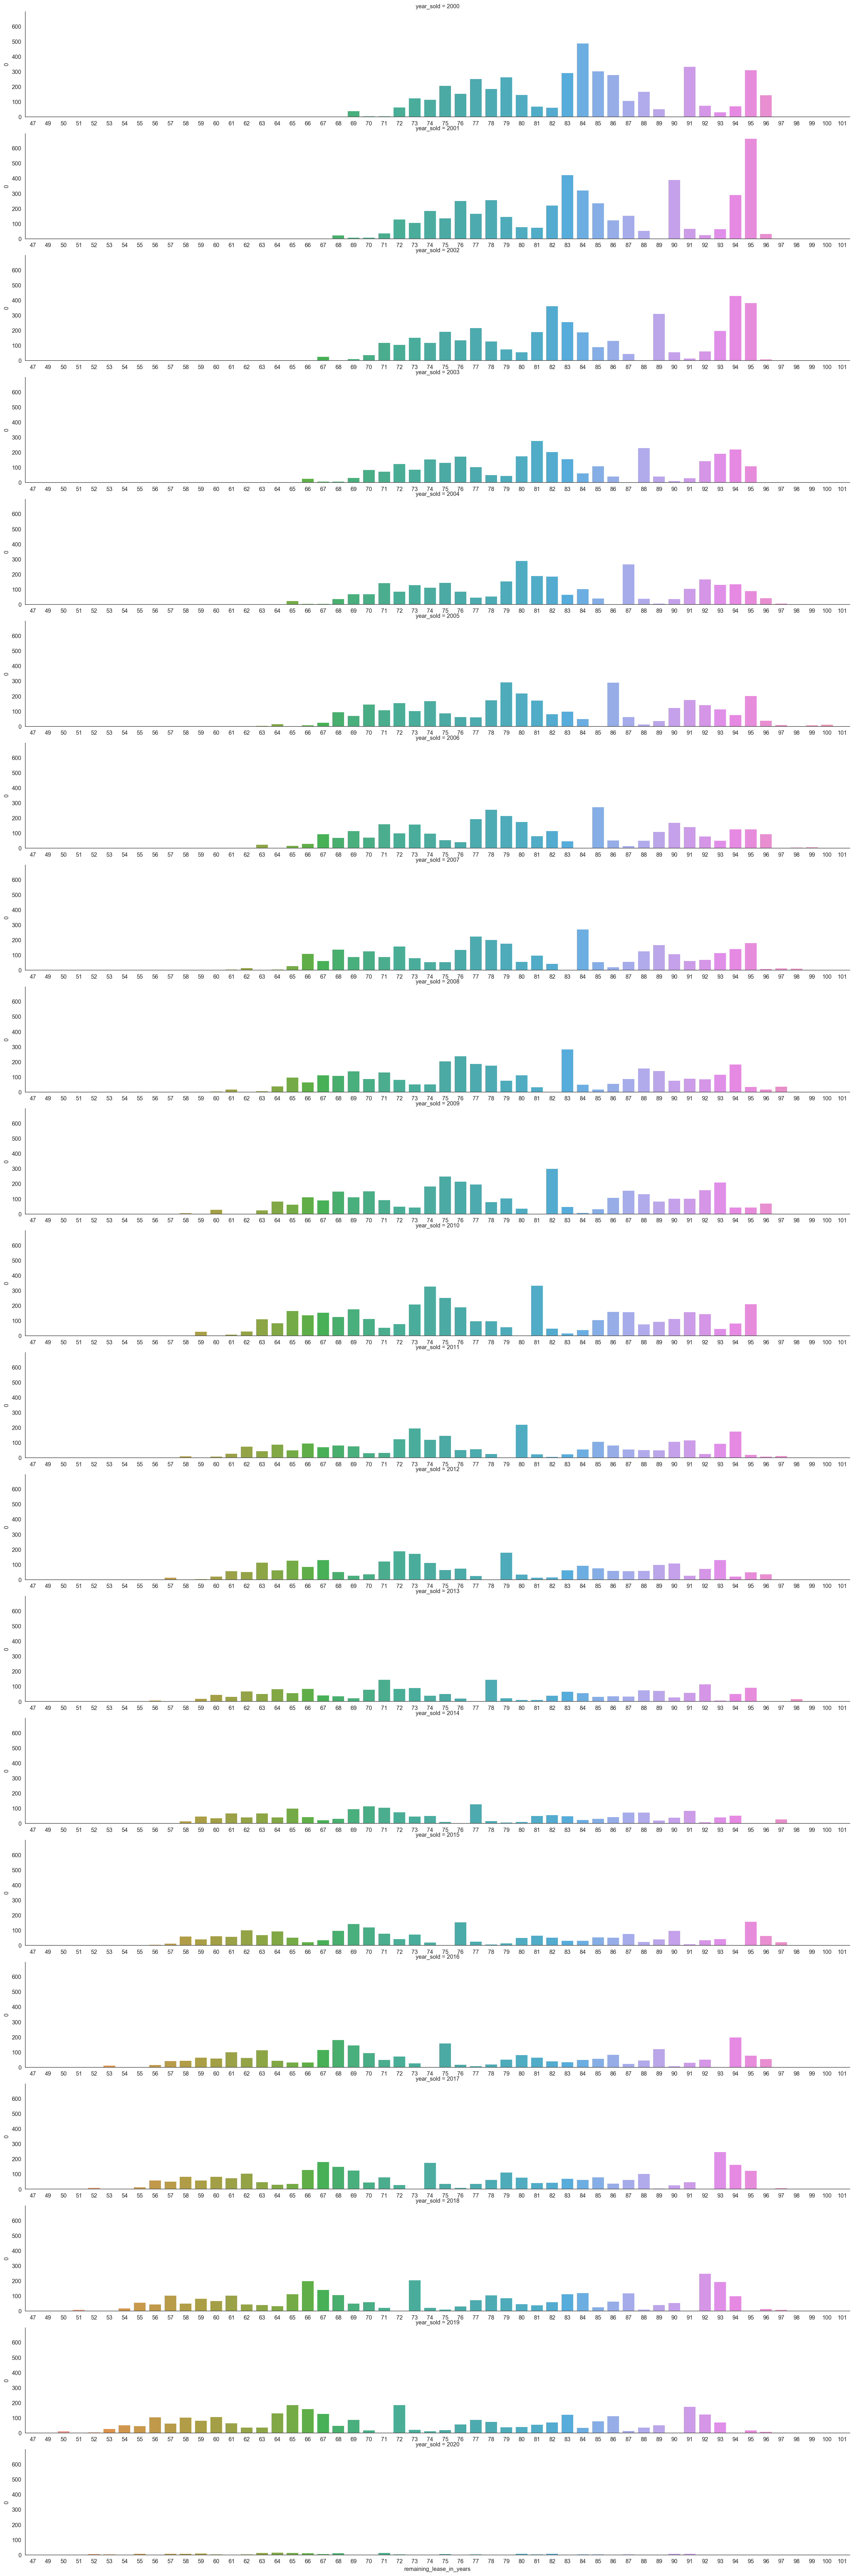

In [30]:
g = sns.catplot(x='remaining_lease_in_years', y=0, col='year_sold', col_wrap=1, data=flats_sold_counts, 
            kind='bar', height=3, aspect=7)

# for ax in g.axes.flatten():
#     ax.tick_params(labelbottom=True)

for ax in g.axes.flat:
    _ = plt.setp(ax.get_xticklabels(), visible=True)

Looks like there are batches of flats!

In Year 2000, the peaks are:
- 84 years remaining lease = built in 1985
- 91 years remaining lease = built in 1992
- 95 years remaining lease = built in 1996

In Year 2001, in addition to the above, a new peak in 
- 95 years remaining lease = built in 1997

In 2010, 
- 74 years remaining lease = built in 1985 (same batch as before)
- 81 years remaining lease = built in 1992
- (new) 95 years remaining lease = built in 2006

In 2015, 
- 95 years remaining lease = built in 2012

In [31]:
danchel = (
    (hdb['town']=='ANG MO KIO') &
    (hdb['flat_type'] == '5 ROOM') &
    (hdb['resale_price'] < 500000) &
    (hdb['year_sold'] == 2019)
)
hdb[danchel]

month  year_sold        town flat_type block        street_name  \
42445 2019-01-01       2019  ANG MO KIO    5 ROOM   553  ANG MO KIO AVE 10   
43986 2019-02-01       2019  ANG MO KIO    5 ROOM   622   ANG MO KIO AVE 9   
46976 2019-04-01       2019  ANG MO KIO    5 ROOM   642   ANG MO KIO AVE 5   
50945 2019-06-01       2019  ANG MO KIO    5 ROOM   460  ANG MO KIO AVE 10   
50947 2019-06-01       2019  ANG MO KIO    5 ROOM   401  ANG MO KIO AVE 10   
56850 2019-09-01       2019  ANG MO KIO    5 ROOM   460  ANG MO KIO AVE 10   
58677 2019-10-01       2019  ANG MO KIO    5 ROOM   102   ANG MO KIO AVE 3   
60864 2019-11-01       2019  ANG MO KIO    5 ROOM   501   ANG MO KIO AVE 5   
60866 2019-11-01       2019  ANG MO KIO    5 ROOM   648   ANG MO KIO AVE 5   
62805 2019-12-01       2019  ANG MO KIO    5 ROOM   439  ANG MO KIO AVE 10   

      storey_range  floor_area_sqm  floor_area_sqft  price_per_sqft  \
42445     01 TO 03           119.0        1280.9041      366.928328   
43986     01 TO 03           121.0        1302.4319      368.541342   
46976     10 TO 12           121.0        1302.4319      360.863397   
50945     04 TO 06           124.0        1334.7236      359.625019   
50947     01 TO 03           119.0        1280.9041      343.507371   
56850     01 TO 03           120.0        1291.6680      364.644785   
58677     01 TO 03           127.0        1367.0153      364.297313   
60864     10 TO 12           121.0        1302.4319      364.702369   
60866     01 TO 03           121.0        1302.4319      376.219286   
62805     04 TO 06           119.0        1280.9041      380.980902   

      flat_model lease_commence_date  lease_commence_year  \
42445   Improved          1980-01-01                 1980   
43986   Improved          1980-01-01                 1980   
46976   Improved          1980-01-01                 1980   
50945   Improved          1980-01-01                 1980   
50947   Improved          1979-01-01                 1979   
56850   Improved          1980-01-01                 1980   
58677   Improved          1993-01-01                 1993   
60864   Improved          1981-01-01                 1981   
60866   Improved          1980-01-01                 1980   
62805   Improved          1979-01-01                 1979   

       remaining_lease_in_years  remaining_lease_in_5Y_buckets  resale_price  
42445                        60                             60      470000.0  
43986                        60                             60      480000.0  
46976                        60                             60      470000.0  
50945                        60                             60      480000.0  
50947                        59                             55      440000.0  
56850                        60                             60      471000.0  
58677                        73                             70      498000.0  
60864                        61                             60      475000.0  
60866                        60                             60      490000.0  
62805                        59                             55      488000.0

In [32]:
# validate some of these: 
# https://www.straitstimes.com/singapore/housing/to-buy-an-old-hdb-flat-or-not-that-is-the-question

In [33]:
# what is the oldest priced flat that we can buy
# count of how many flats sold for each remaining lease year (by year sold?)

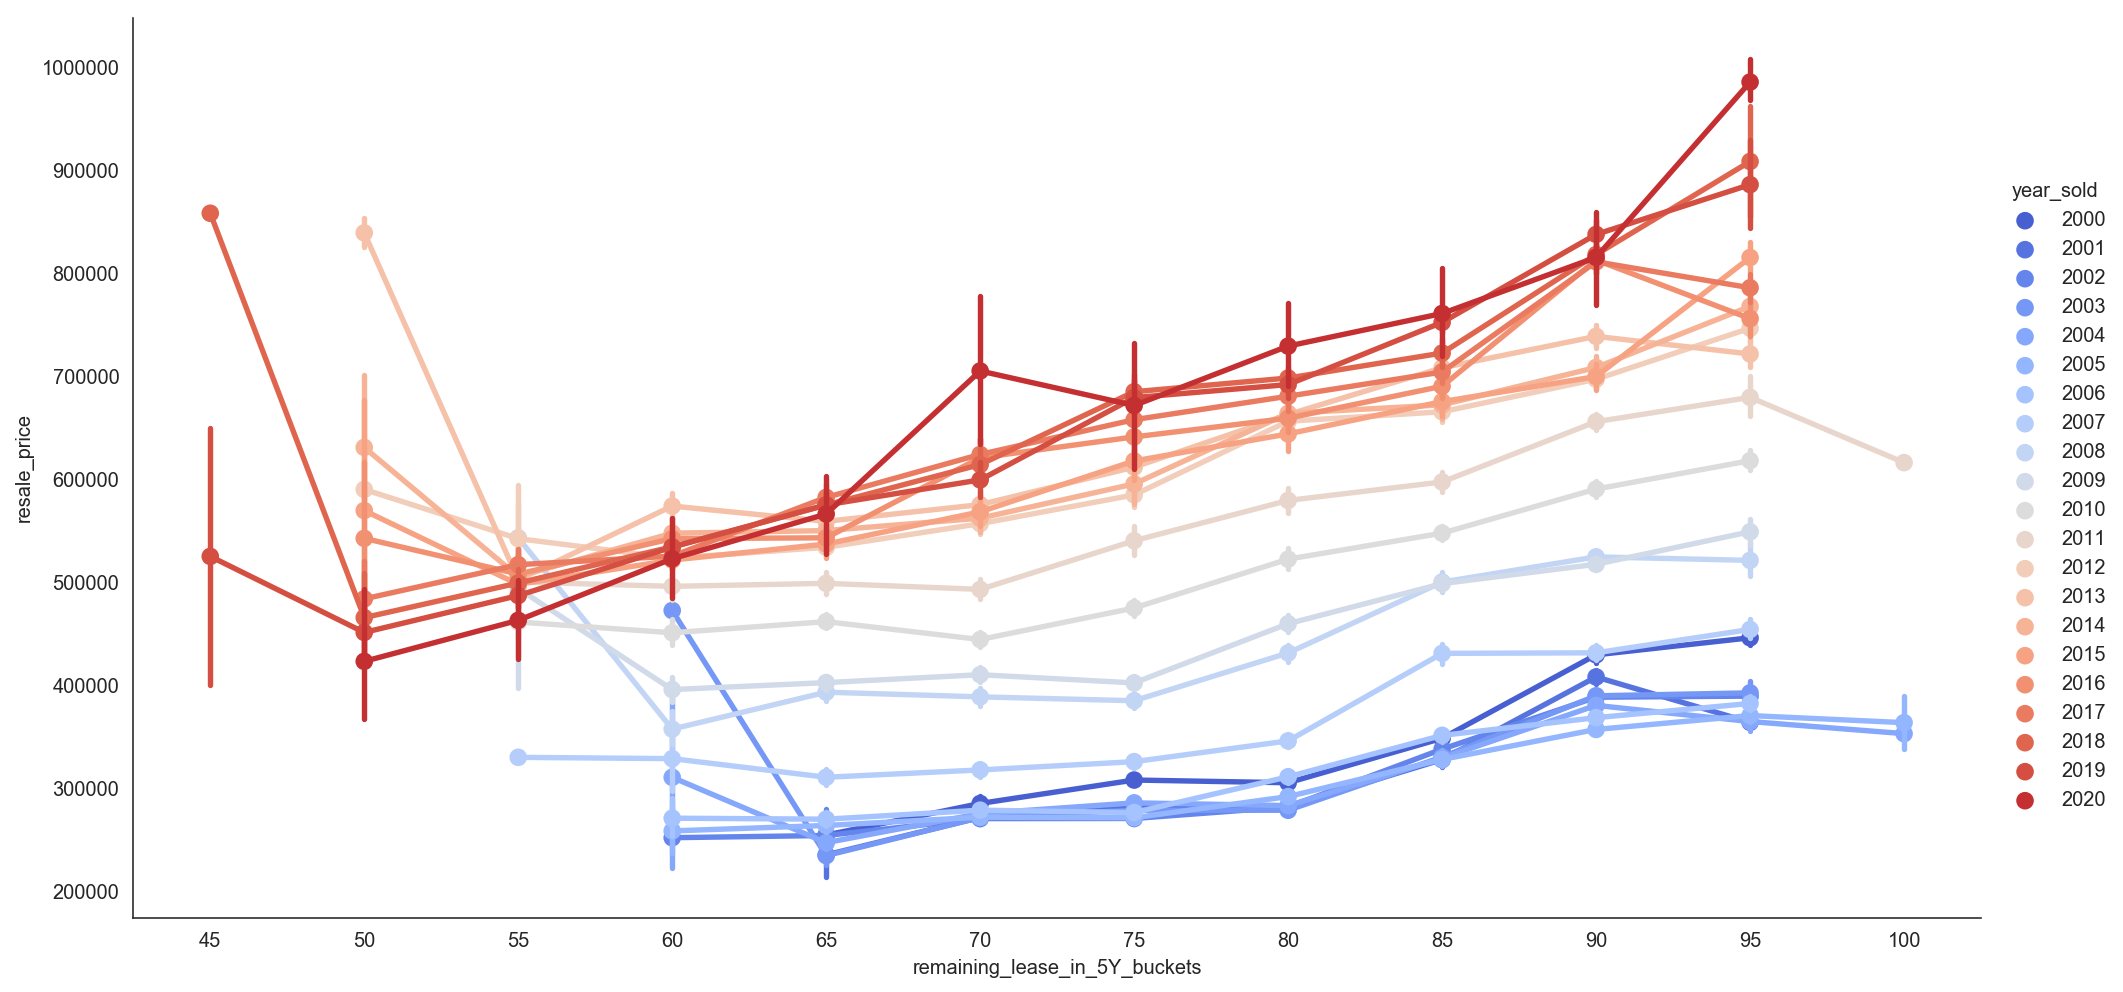

In [34]:
# plot by year sold, resale price, remaining lease as series
hdb_4room_plus_tier_1[['year_sold', 'remaining_lease_in_years', 'remaining_lease_in_5Y_buckets', 'resale_price']]

sns.catplot(x='remaining_lease_in_5Y_buckets', y='resale_price', hue='year_sold', 
            data=hdb_4room_plus_tier_1, kind='point', height=7, aspect=2, alpha=0.3, palette='coolwarm')

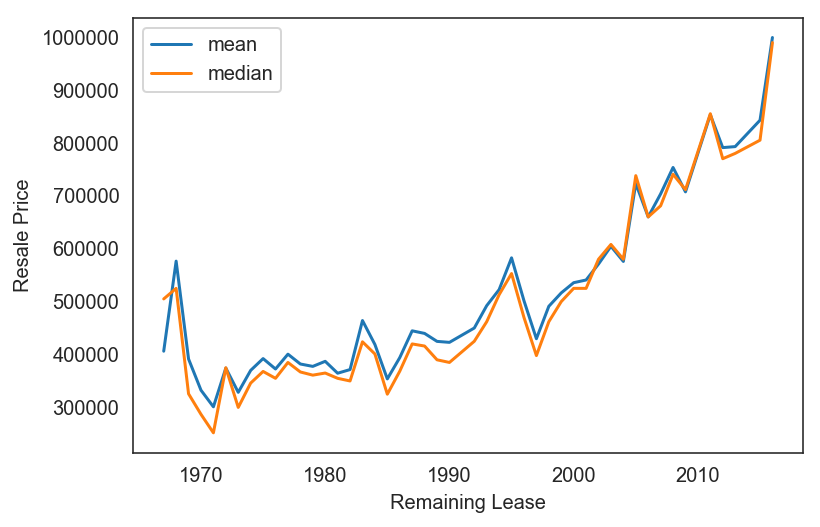

In [35]:
resale_prices_4roomsplus_tier1_by_remaining_lease = (
    hdb_4room_plus_tier_1
    .groupby('remaining_lease_in_years')
    .agg(
        {
            'resale_price': [np.mean, np.median, 'count'],
            'price_per_sqft': [np.mean, np.median, 'count']
        }
        )
)

fig, ax = plt.subplots()

x = resale_prices_4roomsplus_tier1_by_year_built.index.to_list()
y = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['mean']
y2 = resale_prices_4roomsplus_tier1_by_year_built['resale_price']['median']

ax.plot(x, y)
ax.plot(x, y2)
ax.set_xlabel('Remaining Lease')
ax.set_ylabel('Resale Price')
plt.legend();

In [36]:
# are there flats that were built in a certain time range that are more popular?
# correlation between year hdb was made vs resale price



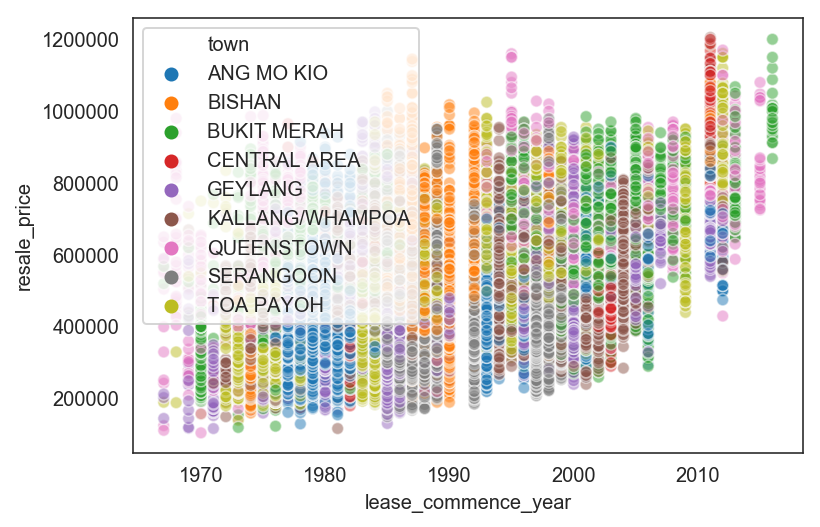

In [37]:
sns.scatterplot(x='lease_commence_year', y='resale_price', data=hdb_4room_plus_tier_1, alpha=0.5, hue='town');

In [38]:
hdb[['lease_commence_year', 'resale_price']].corr()

lease_commence_year  resale_price
lease_commence_year             1.000000      0.422979
resale_price                    0.422979      1.000000

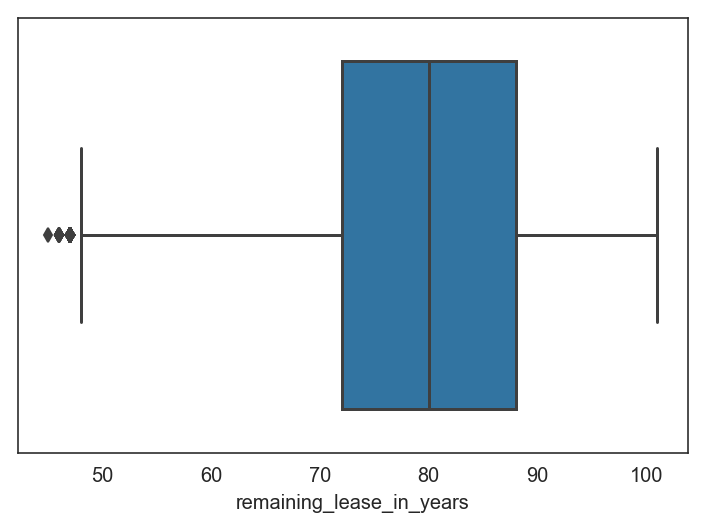

In [39]:
sns.boxplot(hdb['remaining_lease_in_years'])

(array([  1005.,   6358.,  18335.,  48344.,  63855.,  96103., 103721.,
         69412., 112267.,   6104.]),
 array([ 45. ,  50.6,  56.2,  61.8,  67.4,  73. ,  78.6,  84.2,  89.8,
         95.4, 101. ]),
 <a list of 10 Patch objects>)

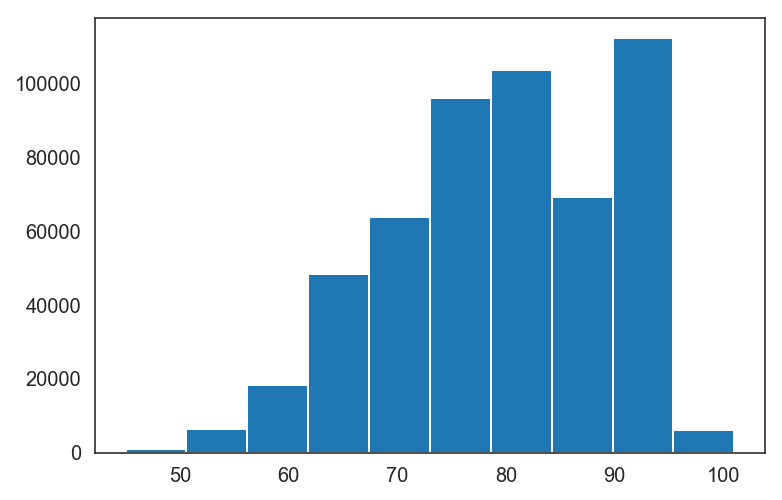

In [40]:
plt.hist(hdb['remaining_lease_in_years'])

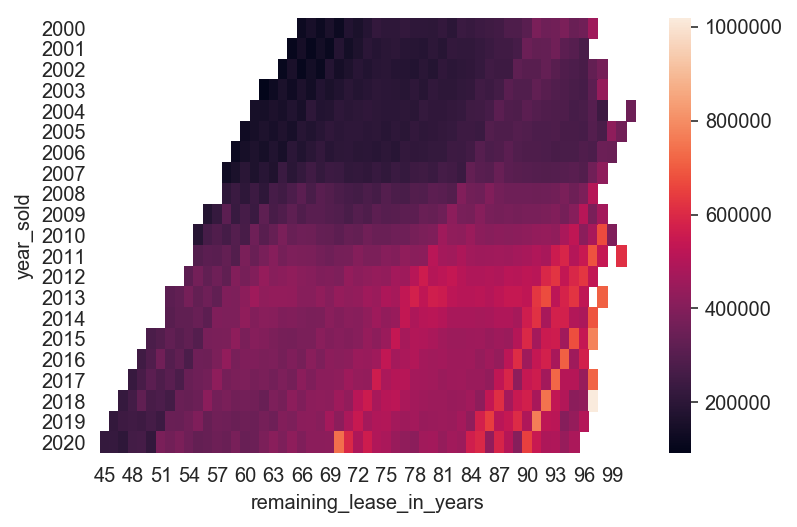

In [41]:
sns.heatmap(hdb.groupby(['year_sold', 'remaining_lease_in_years'])['resale_price'].mean().unstack())